In [1]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [5]:
%matplotlib inline

In [6]:
%%html
<style>
table {float:left;}
</style>

## Tool Modules

In [7]:
from quantum import *
from measurements import *

from unitary import *
from VQC import *

from dataSL import *
from QOLearner import *

from noise import *
from lipschitz import *

## Prepare Circuits

### - Input Circuits

In [16]:
def getOriginCircuit(bits, decode=False):
    circuit = QuantumCircuit(2, 2)
    
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.barrier(0)
    circuit.barrier(1)
    
    # encode 
    if bits[0] == '1':
        circuit.z(0)
    if bits[1] == '1':
        circuit.x(0)
    
    circuit.barrier()
    
    if decode:
        circuit.cx(0, 1)
        circuit.h(0)

    return circuit

In [17]:
# S-attack at end of Alice
def hack(circuit):
    circuit.s(0)
    
    return circuit

In [18]:
inputCircuits = []
inputHackedCircuits = []
classical_bits = ["00", "10", "01", "11"]

for bits in classical_bits:
    inputCircuits.append(getOriginCircuit(bits))
    inputHackedCircuits.append(hack(getOriginCircuit(bits)))

print(len(inputCircuits))
print(len(inputHackedCircuits))

4
4


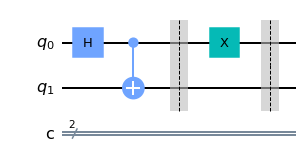

In [19]:
inputCircuits[2].draw(output='mpl')

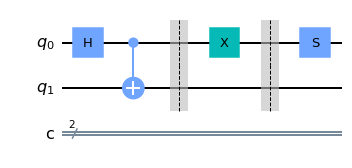

In [20]:
inputHackedCircuits[2].draw(output='mpl')

### - Output Circuits

In [21]:
def getOutputCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

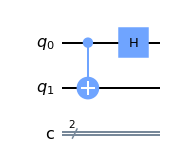

In [22]:
outputCircuit = getOutputCircuit(1)
outputCircuit.draw(output='mpl')

## Train paramters

In [23]:
import time
import sys
stdout = sys.stdout

In [24]:
# experiments times
MAX_TIMES = 10

In [25]:
class QOLearner(QOLearnerBase):
    def __init__(self, circuits, n, pos):
        super().__init__(circuits, n, pos, {}) # empty expected
        
    def cost(self, circuit, hacked_circuit, index):
        rou = getStatevector(circuit)
        sigma = getStatevector(hacked_circuit)
        loss = 0.0
        
        for i in range(len(self.measurements)):
            p = measure(self.measurements[i], rou)
            q = measure(self.measurements[i], sigma)
            
            if i != index:
                loss += p ** 2 + q ** 2
            else:
                loss += (1 - p) ** 2 + (1 - q) ** 2
                
            
        return loss / len(self.measurements) / 2
    
    def L(self, p):
        loss = 0.0
        
        for (circuit_index, circuit) in enumerate(self.circuits[0]):
            # input circuit
            circuit = circuit.copy()
            hacked_circuit = circuit.copy()
            hacked_circuit = hack(hacked_circuit)
            
            # parametered part => unitary gate / VQC
            if self.strategy == 'unitary':
                U = buildU(self.n, p)
                circuit.append(U, self.pos)
                hacked_circuit.append(U, self.pos)
            else:
                index = 0
                for layer in range(self.vqc_layers_num):
                    for i in range(self.n):
                        circuit.u2(p[index], p[index + 1], self.pos[i])
                        hacked_circuit.u2(p[index], p[index + 1], self.pos[i])
                        index += 2

                    if layer + 1 == self.vqc_layers_num:
                        break

                    for i in range(self.n):
                        if i + 1 != self.n:
                            circuit.cx(self.pos[i], self.pos[i + 1])
                            hacked_circuit.cx(self.pos[i], self.pos[i + 1])
                        elif self.n > 2:
                            circuit.cx(self.pos[i], self.pos[0])
                            hacked_circuit.cx(self.pos[i], self.pos[0])

            # remained circuit
            circuit = circuit.compose(self.circuits[1])
            hacked_circuit = hacked_circuit.compose(self.circuits[1])
            
            loss += self.cost(circuit, hacked_circuit, circuit_index)
    
        return loss

## Strategy: unitary

In [21]:
qol_unitary = QOLearner([inputCircuits, outputCircuit], 2, [0, 1])

In [66]:
times_unitary = []

for i in range(MAX_TIMES):
    start = time.perf_counter()
    qol_unitary.fit(epoch=1000, strategy='unitary', stepsize=0.003, early_stopping=True)
    end = time.perf_counter()
    times_unitary.append(end - start)
    
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_unitary.params[-1], 'sAttack', 'unitary', i + 1)
    saveLosses(qol_unitary.losses, 'sAttack', 'unitary', i + 1)

epoch: [1/1000] - loss: (0.8905142049934438+0j) end.
epoch: [2/1000] - loss: (0.8833373949758443+0j) end.
epoch: [3/1000] - loss: (0.8761487015239456+0j) end.
epoch: [4/1000] - loss: (0.868950811527663+0j) end.
epoch: [5/1000] - loss: (0.8617459249120238+0j) end.
epoch: [6/1000] - loss: (0.8545361297474441+0j) end.
epoch: [7/1000] - loss: (0.8473232701624099+0j) end.
epoch: [8/1000] - loss: (0.8401089512608778+0j) end.
epoch: [9/1000] - loss: (0.8328946029759037+0j) end.
epoch: [10/1000] - loss: (0.8256815623006605+0j) end.
epoch: [11/1000] - loss: (0.818471289790438+0j) end.
epoch: [12/1000] - loss: (0.8112649908616036+0j) end.
epoch: [13/1000] - loss: (0.8040637493553967+0j) end.
epoch: [14/1000] - loss: (0.7968684204770277+0j) end.
epoch: [15/1000] - loss: (0.7896793213875339+0j) end.
epoch: [16/1000] - loss: (0.7824962252524768+0j) end.
epoch: [17/1000] - loss: (0.7753185880496138+0j) end.
epoch: [18/1000] - loss: (0.768145302231676+0j) end.
epoch: [19/1000] - loss: (0.760974909125

epoch: [151/1000] - loss: (0.05682523734919141+0j) end.
epoch: [152/1000] - loss: (0.05652293716177637+0j) end.
epoch: [153/1000] - loss: (0.05623430845823497+0j) end.
epoch: [154/1000] - loss: (0.055958589938965714+0j) end.
epoch: [155/1000] - loss: (0.05569508703697574+0j) end.
epoch: [156/1000] - loss: (0.05544312644074342+0j) end.
epoch: [157/1000] - loss: (0.05520209378013803+0j) end.
epoch: [158/1000] - loss: (0.05497136603139845+0j) end.
epoch: [159/1000] - loss: (0.05475038991157256+0j) end.
epoch: [160/1000] - loss: (0.05453862758905725+0j) end.
epoch: [161/1000] - loss: (0.05433557701962187+0j) end.
epoch: [162/1000] - loss: (0.054140742384329574+0j) end.
epoch: [163/1000] - loss: (0.05395369175684149+0j) end.
epoch: [164/1000] - loss: (0.053773983571498055+0j) end.
epoch: [165/1000] - loss: (0.05360121838740389+0j) end.
epoch: [166/1000] - loss: (0.05343501252396751+0j) end.
epoch: [167/1000] - loss: (0.05327500900000209+0j) end.
epoch: [168/1000] - loss: (0.0531208635747280

epoch: [297/1000] - loss: (0.046797690315473504+0j) end.
epoch: [298/1000] - loss: (0.04678199884870139+0j) end.
epoch: [299/1000] - loss: (0.04676649469201553+0j) end.
epoch: [300/1000] - loss: (0.0467511801961277+0j) end.
epoch: [301/1000] - loss: (0.04673604877676727+0j) end.
epoch: [302/1000] - loss: (0.04672109932442867+0j) end.
epoch: [303/1000] - loss: (0.046706328570873756+0j) end.
epoch: [304/1000] - loss: (0.04669173410855932+0j) end.
epoch: [305/1000] - loss: (0.04667731132977109+0j) end.
epoch: [306/1000] - loss: (0.04666305989550626+0j) end.
epoch: [307/1000] - loss: (0.046648974916618235+0j) end.
epoch: [308/1000] - loss: (0.04663505409136597+0j) end.
epoch: [309/1000] - loss: (0.04662129635053888+0j) end.
epoch: [310/1000] - loss: (0.04660769656310949+0j) end.
epoch: [311/1000] - loss: (0.04659425423175054+0j) end.
epoch: [312/1000] - loss: (0.046580966426772126+0j) end.
epoch: [313/1000] - loss: (0.04656782956196353+0j) end.
epoch: [314/1000] - loss: (0.0465548417320123

epoch: [109/1000] - loss: (0.16025648729387093+0j) end.
epoch: [110/1000] - loss: (0.15718939782231436+0j) end.
epoch: [111/1000] - loss: (0.15423552384317846+0j) end.
epoch: [112/1000] - loss: (0.15139131309779816+0j) end.
epoch: [113/1000] - loss: (0.14865311717642304+0j) end.
epoch: [114/1000] - loss: (0.14601747566699042+0j) end.
epoch: [115/1000] - loss: (0.14348084367170896+0j) end.
epoch: [116/1000] - loss: (0.14103975908016458+0j) end.
epoch: [117/1000] - loss: (0.1386908548585261+0j) end.
epoch: [118/1000] - loss: (0.1364307717940792+0j) end.
epoch: [119/1000] - loss: (0.13425621488415623+0j) end.
epoch: [120/1000] - loss: (0.13216399957381328+0j) end.
epoch: [121/1000] - loss: (0.13015095168878033+0j) end.
epoch: [122/1000] - loss: (0.12821406746376524+0j) end.
epoch: [123/1000] - loss: (0.12635031772218824+0j) end.
epoch: [124/1000] - loss: (0.12455682392882898+0j) end.
epoch: [125/1000] - loss: (0.12283077616136502+0j) end.
epoch: [126/1000] - loss: (0.12116941049959103+0j)

epoch: [256/1000] - loss: (0.06982073855815246+0j) end.
epoch: [257/1000] - loss: (0.06974153227144653+0j) end.
epoch: [258/1000] - loss: (0.06966308249519707+0j) end.
epoch: [259/1000] - loss: (0.06958538448823554+0j) end.
epoch: [260/1000] - loss: (0.0695084119986838+0j) end.
epoch: [261/1000] - loss: (0.06943214690384589+0j) end.
epoch: [262/1000] - loss: (0.06935657145710522+0j) end.
epoch: [263/1000] - loss: (0.0692816679347607+0j) end.
epoch: [264/1000] - loss: (0.06920741648509673+0j) end.
epoch: [265/1000] - loss: (0.0691338030795147+0j) end.
epoch: [266/1000] - loss: (0.06906081052652013+0j) end.
epoch: [267/1000] - loss: (0.06898842034126865+0j) end.
epoch: [268/1000] - loss: (0.06891662520547914+0j) end.
epoch: [269/1000] - loss: (0.06884540018928757+0j) end.
epoch: [270/1000] - loss: (0.06877474097281466+0j) end.
epoch: [271/1000] - loss: (0.06870462907259113+0j) end.
epoch: [272/1000] - loss: (0.06863504681654822+0j) end.
epoch: [273/1000] - loss: (0.06856598820294901+0j) 

epoch: [403/1000] - loss: (0.061815788508857404+0j) end.
epoch: [404/1000] - loss: (0.061774063221762786+0j) end.
epoch: [405/1000] - loss: (0.06173245333976169+0j) end.
epoch: [406/1000] - loss: (0.06169095602412044+0j) end.
epoch: [407/1000] - loss: (0.06164957438188459+0j) end.
epoch: [408/1000] - loss: (0.06160830963461708+0j) end.
epoch: [409/1000] - loss: (0.06156715760699766+0j) end.
epoch: [410/1000] - loss: (0.0615261213673293+0j) end.
epoch: [411/1000] - loss: (0.061485197476872894+0j) end.
epoch: [412/1000] - loss: (0.06144439085456377+0j) end.
epoch: [413/1000] - loss: (0.06140369160805305+0j) end.
epoch: [414/1000] - loss: (0.06136310686364378+0j) end.
epoch: [415/1000] - loss: (0.06132263495330991+0j) end.
epoch: [416/1000] - loss: (0.06128227374644621+0j) end.
epoch: [417/1000] - loss: (0.06124202710978993+0j) end.
epoch: [418/1000] - loss: (0.061201890104349996+0j) end.
epoch: [419/1000] - loss: (0.06116186272108303+0j) end.
epoch: [420/1000] - loss: (0.0611219467917377

epoch: [549/1000] - loss: (0.05678994002650273+0j) end.
epoch: [550/1000] - loss: (0.05676189445405966+0j) end.
epoch: [551/1000] - loss: (0.05673392208871263+0j) end.
epoch: [552/1000] - loss: (0.056706023370429896+0j) end.
epoch: [553/1000] - loss: (0.0566781995915262+0j) end.
epoch: [554/1000] - loss: (0.05665044534629081+0j) end.
epoch: [555/1000] - loss: (0.05662276708463404+0j) end.
epoch: [556/1000] - loss: (0.05659516068041495+0j) end.
epoch: [557/1000] - loss: (0.05656762450842704+0j) end.
epoch: [558/1000] - loss: (0.056540162454825064+0j) end.
epoch: [559/1000] - loss: (0.05651277234770288+0j) end.
epoch: [560/1000] - loss: (0.05648545215003559+0j) end.
epoch: [561/1000] - loss: (0.056458203674211734+0j) end.
epoch: [562/1000] - loss: (0.05643102665332732+0j) end.
epoch: [563/1000] - loss: (0.05640391983632277+0j) end.
epoch: [564/1000] - loss: (0.056376883633894315+0j) end.
epoch: [565/1000] - loss: (0.05634992029473791+0j) end.
epoch: [566/1000] - loss: (0.0563230234463326

epoch: [695/1000] - loss: (0.05336454178557449+0j) end.
epoch: [696/1000] - loss: (0.05334503726012736+0j) end.
epoch: [697/1000] - loss: (0.05332557696257181+0j) end.
epoch: [698/1000] - loss: (0.05330616005463996+0j) end.
epoch: [699/1000] - loss: (0.0532867898314975+0j) end.
epoch: [700/1000] - loss: (0.05326746393528585+0j) end.
epoch: [701/1000] - loss: (0.05324818491096163+0j) end.
epoch: [702/1000] - loss: (0.053228947770246685+0j) end.
epoch: [703/1000] - loss: (0.053209758660539105+0j) end.
epoch: [704/1000] - loss: (0.05319061102831514+0j) end.
epoch: [705/1000] - loss: (0.05317151041530695+0j) end.
epoch: [706/1000] - loss: (0.053152450805136066+0j) end.
epoch: [707/1000] - loss: (0.05313343680637639+0j) end.
epoch: [708/1000] - loss: (0.05311446776095506+0j) end.
epoch: [709/1000] - loss: (0.05309554032556888+0j) end.
epoch: [710/1000] - loss: (0.053076656648995385+0j) end.
epoch: [711/1000] - loss: (0.05305781794696625+0j) end.
epoch: [712/1000] - loss: (0.0530390217273051

epoch: [841/1000] - loss: (0.05093249905060823+0j) end.
epoch: [842/1000] - loss: (0.05091832712648578+0j) end.
epoch: [843/1000] - loss: (0.05090418516735436+0j) end.
epoch: [844/1000] - loss: (0.05089007318467082+0j) end.
epoch: [845/1000] - loss: (0.05087598871761119+0j) end.
epoch: [846/1000] - loss: (0.05086193491834879+0j) end.
epoch: [847/1000] - loss: (0.050847908450961835+0j) end.
epoch: [848/1000] - loss: (0.050833910422184936+0j) end.
epoch: [849/1000] - loss: (0.05081994147210674+0j) end.
epoch: [850/1000] - loss: (0.05080600141724608+0j) end.
epoch: [851/1000] - loss: (0.05079208869867441+0j) end.
epoch: [852/1000] - loss: (0.05077820548120493+0j) end.
epoch: [853/1000] - loss: (0.05076434871727528+0j) end.
epoch: [854/1000] - loss: (0.05075052242262684+0j) end.
epoch: [855/1000] - loss: (0.05073672235261634+0j) end.
epoch: [856/1000] - loss: (0.05072295078347808+0j) end.
epoch: [857/1000] - loss: (0.050709206854591994+0j) end.
epoch: [858/1000] - loss: (0.0506954931836786

epoch: [987/1000] - loss: (0.04913398939417565+0j) end.
epoch: [988/1000] - loss: (0.04912331896627923+0j) end.
epoch: [989/1000] - loss: (0.049112668909224305+0j) end.
epoch: [990/1000] - loss: (0.04910203857203838+0j) end.
epoch: [991/1000] - loss: (0.04909142785935037+0j) end.
epoch: [992/1000] - loss: (0.04908083696295636+0j) end.
epoch: [993/1000] - loss: (0.04907026496300656+0j) end.
epoch: [994/1000] - loss: (0.04905971221610667+0j) end.
epoch: [995/1000] - loss: (0.04904917950993769+0j) end.
epoch: [996/1000] - loss: (0.04903866588234132+0j) end.
epoch: [997/1000] - loss: (0.04902817180031224+0j) end.
epoch: [998/1000] - loss: (0.049017696808894715+0j) end.
epoch: [999/1000] - loss: (0.04900724115039375+0j) end.
epoch: [1000/1000] - loss: (0.04899680348467097+0j) end.
Fin - No. 2
epoch: [1/1000] - loss: (0.9668909722071263+0j) end.
epoch: [2/1000] - loss: (0.9610444759681445+0j) end.
epoch: [3/1000] - loss: (0.9552420214499151+0j) end.
epoch: [4/1000] - loss: (0.949488711276421

epoch: [137/1000] - loss: (0.10419940888559424+0j) end.
epoch: [138/1000] - loss: (0.10325217106251171+0j) end.
epoch: [139/1000] - loss: (0.10233946663748963+0j) end.
epoch: [140/1000] - loss: (0.10145942100952177+0j) end.
epoch: [141/1000] - loss: (0.10061042754566896+0j) end.
epoch: [142/1000] - loss: (0.09979082943649675+0j) end.
epoch: [143/1000] - loss: (0.09899914618355748+0j) end.
epoch: [144/1000] - loss: (0.0982339948643513+0j) end.
epoch: [145/1000] - loss: (0.09749400583501654+0j) end.
epoch: [146/1000] - loss: (0.09677797323776241+0j) end.
epoch: [147/1000] - loss: (0.09608472061881289+0j) end.
epoch: [148/1000] - loss: (0.0954131518784397+0j) end.
epoch: [149/1000] - loss: (0.09476220981890342+0j) end.
epoch: [150/1000] - loss: (0.0941309594501579+0j) end.
epoch: [151/1000] - loss: (0.09351844632874035+0j) end.
epoch: [152/1000] - loss: (0.09292382206915761+0j) end.
epoch: [153/1000] - loss: (0.09234629588062923+0j) end.
epoch: [154/1000] - loss: (0.09178507906468075+0j) 

epoch: [284/1000] - loss: (0.06511211072787289+0j) end.
epoch: [285/1000] - loss: (0.065028504856441+0j) end.
epoch: [286/1000] - loss: (0.06494552280888422+0j) end.
epoch: [287/1000] - loss: (0.06486316779037651+0j) end.
epoch: [288/1000] - loss: (0.06478141967624382+0j) end.
epoch: [289/1000] - loss: (0.06470027495086553+0j) end.
epoch: [290/1000] - loss: (0.06461972182132852+0j) end.
epoch: [291/1000] - loss: (0.06453975428063362+0j) end.
epoch: [292/1000] - loss: (0.06446035991595508+0j) end.
epoch: [293/1000] - loss: (0.06438153333953514+0j) end.
epoch: [294/1000] - loss: (0.06430326069558294+0j) end.
epoch: [295/1000] - loss: (0.06422553749785842+0j) end.
epoch: [296/1000] - loss: (0.06414836096101366+0j) end.
epoch: [297/1000] - loss: (0.06407171091159725+0j) end.
epoch: [298/1000] - loss: (0.0639955897976077+0j) end.
epoch: [299/1000] - loss: (0.06391998615122568+0j) end.
epoch: [300/1000] - loss: (0.06384488980761473+0j) end.
epoch: [301/1000] - loss: (0.06377029756866648+0j) 

KeyboardInterrupt: 

In [50]:
print(f'Average times for unitary: {np.mean(times_unitary)}')

Average times for unitary: 202.4901238


### - plot a loss example

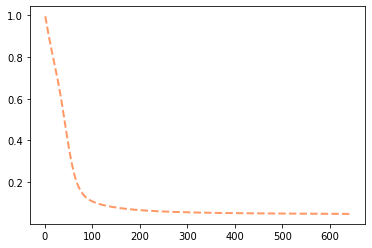

In [25]:
plot(loadLosses('sAttack', 'unitary', 3), color=palette['unitary'])

In [13]:
losses_unitary= []
max_length = 0
for i in range(MAX_TIMES):
    losses_unitary.append(loadLosses('sAttack', 'unitary', i + 1))
    max_length = max(max_length, len(losses_unitary[-1]))

for i in range(MAX_TIMES):
    length = len(losses_unitary[i])
    while length < max_length:
        losses_unitary[i].append(losses_unitary[i][-1])
        length += 1

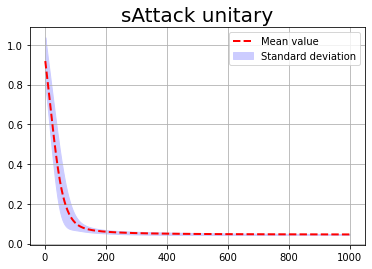

In [14]:
plotLosses(losses_unitary, title='sAttack unitary')

### - average time and loss

In [51]:
average_loss_unitary = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sAttack', 'unitary', i + 1)[-1]
    average_loss_unitary += loss
print(f'Average loss for unitary: {average_loss_unitary / MAX_TIMES}')

Average loss for unitary: (0.04516207478153306+0j)


In [52]:
average_epoch_unitary = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sAttack', 'unitary', i + 1)
    average_epoch_unitary += len(loss)
print(f'Average epoch for unitary: {average_epoch_unitary / MAX_TIMES}')

Average epoch for unitary: 524.0


In [53]:
average_time_unitary = 202.4901238

In [54]:
average_time_per_epoch_unitary = average_time_unitary / average_epoch_unitary
print(f'Average time per epoch for unitary: {average_time_per_epoch_unitary}')

Average time per epoch for unitary: 0.038643153396946565


|Strategy| parameterized unitary |
|:----------------:|:-----:|
| Average loss | 0.04516 |
| Average time | 202.49 |
| Average epochs | 524.0 |
| Average time per epoch | 0.03864 |

## Strategy: VQC

In [23]:
qol_vqc = QOLearner([inputCircuits, outputCircuit], 2, [0, 1])

In [24]:
times_vqc = []

for i in range(MAX_TIMES):
    start = time.perf_counter()
    qol_vqc.fit(epoch=1000, strategy='vqc', stepsize=0.005, early_stopping=True)
    end = time.perf_counter()
    times_vqc.append(end - start)
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_vqc.params[-1], 'sAttack', 'vqc', i + 1)
    saveLosses(qol_vqc.losses, 'sAttack', 'vqc', i + 1)

epoch: [1/1000] - loss: (0.7221873908718393+0j) end.
epoch: [2/1000] - loss: (0.7179666960186257+0j) end.
epoch: [3/1000] - loss: (0.7137477653041667+0j) end.
epoch: [4/1000] - loss: (0.7095349513398527+0j) end.
epoch: [5/1000] - loss: (0.7053307648782003+0j) end.
epoch: [6/1000] - loss: (0.7011341541108668+0j) end.
epoch: [7/1000] - loss: (0.696938286222894+0j) end.
epoch: [8/1000] - loss: (0.6927291668322328+0j) end.
epoch: [9/1000] - loss: (0.6884870372375933+0j) end.
epoch: [10/1000] - loss: (0.6841900620217736+0j) end.
epoch: [11/1000] - loss: (0.6798174182671466+0j) end.
epoch: [12/1000] - loss: (0.6753509660207788+0j) end.
epoch: [13/1000] - loss: (0.6707763368802024+0j) end.
epoch: [14/1000] - loss: (0.6660832921933426+0j) end.
epoch: [15/1000] - loss: (0.6612651286187902+0j) end.
epoch: [16/1000] - loss: (0.6563176441371388+0j) end.
epoch: [17/1000] - loss: (0.6512382232292548+0j) end.
epoch: [18/1000] - loss: (0.6460252313788388+0j) end.
epoch: [19/1000] - loss: (0.6406776753

epoch: [151/1000] - loss: (0.07397972753828529+0j) end.
epoch: [152/1000] - loss: (0.07301333351038536+0j) end.
epoch: [153/1000] - loss: (0.07207084954562865+0j) end.
epoch: [154/1000] - loss: (0.07115195853850408+0j) end.
epoch: [155/1000] - loss: (0.07025633822351351+0j) end.
epoch: [156/1000] - loss: (0.06938366127495753+0j) end.
epoch: [157/1000] - loss: (0.06853359545467136+0j) end.
epoch: [158/1000] - loss: (0.06770580380231363+0j) end.
epoch: [159/1000] - loss: (0.06689994486303219+0j) end.
epoch: [160/1000] - loss: (0.06611567294757603+0j) end.
epoch: [161/1000] - loss: (0.06535263842018782+0j) end.
epoch: [162/1000] - loss: (0.06461048800988552+0j) end.
epoch: [163/1000] - loss: (0.06388886514102633+0j) end.
epoch: [164/1000] - loss: (0.06318741027933925+0j) end.
epoch: [165/1000] - loss: (0.06250576128990014+0j) end.
epoch: [166/1000] - loss: (0.06184355380381726+0j) end.
epoch: [167/1000] - loss: (0.06120042159067707+0j) end.
epoch: [168/1000] - loss: (0.0605759969340799+0j

epoch: [19/1000] - loss: (0.6374761418082537+0j) end.
epoch: [20/1000] - loss: (0.6323720526094796+0j) end.
epoch: [21/1000] - loss: (0.6273299111194335+0j) end.
epoch: [22/1000] - loss: (0.6223435663955235+0j) end.
epoch: [23/1000] - loss: (0.6174060930614538+0j) end.
epoch: [24/1000] - loss: (0.612509798245402+0j) end.
epoch: [25/1000] - loss: (0.6076462418211681+0j) end.
epoch: [26/1000] - loss: (0.6028062726492118+0j) end.
epoch: [27/1000] - loss: (0.5979800834225957+0j) end.
epoch: [28/1000] - loss: (0.5931572863527603+0j) end.
epoch: [29/1000] - loss: (0.5883270112245327+0j) end.
epoch: [30/1000] - loss: (0.5834780262866088+0j) end.
epoch: [31/1000] - loss: (0.578598881056073+0j) end.
epoch: [32/1000] - loss: (0.5736780685059516+0j) end.
epoch: [33/1000] - loss: (0.5687042024457244+0j) end.
epoch: [34/1000] - loss: (0.5636662044184333+0j) end.
epoch: [35/1000] - loss: (0.5585534933567834+0j) end.
epoch: [36/1000] - loss: (0.5533561707540811+0j) end.
epoch: [37/1000] - loss: (0.54

epoch: [169/1000] - loss: (0.07396960842424408+0j) end.
epoch: [170/1000] - loss: (0.07323359708015657+0j) end.
epoch: [171/1000] - loss: (0.07251590761801288+0j) end.
epoch: [172/1000] - loss: (0.07181612643079038+0j) end.
epoch: [173/1000] - loss: (0.07113384533411815+0j) end.
epoch: [174/1000] - loss: (0.07046866171423545+0j) end.
epoch: [175/1000] - loss: (0.06982017866416432+0j) end.
epoch: [176/1000] - loss: (0.0691880051079926+0j) end.
epoch: [177/1000] - loss: (0.06857175591321019+0j) end.
epoch: [178/1000] - loss: (0.0679710519910963+0j) end.
epoch: [179/1000] - loss: (0.0673855203852109+0j) end.
epoch: [180/1000] - loss: (0.06681479434810689+0j) end.
epoch: [181/1000] - loss: (0.0662585134064467+0j) end.
epoch: [182/1000] - loss: (0.06571632341477161+0j) end.
epoch: [183/1000] - loss: (0.06518787659823627+0j) end.
epoch: [184/1000] - loss: (0.06467283158468665+0j) end.
epoch: [185/1000] - loss: (0.06417085342650536+0j) end.
epoch: [186/1000] - loss: (0.06368161361270218+0j) e

epoch: [315/1000] - loss: (0.04446067841375675+0j) end.
epoch: [316/1000] - loss: (0.044431513145779596+0j) end.
epoch: [317/1000] - loss: (0.04440288235657803+0j) end.
epoch: [318/1000] - loss: (0.04437477626735914+0j) end.
epoch: [319/1000] - loss: (0.04434718530824658+0j) end.
epoch: [320/1000] - loss: (0.04432010011243927+0j) end.
epoch: [321/1000] - loss: (0.04429351151056605+0j) end.
epoch: [322/1000] - loss: (0.04426741052522799+0j) end.
epoch: [323/1000] - loss: (0.044241788365723456+0j) end.
epoch: [324/1000] - loss: (0.04421663642294937+0j) end.
epoch: [325/1000] - loss: (0.04419194626447387+0j) end.
epoch: [326/1000] - loss: (0.04416770962977334+0j) end.
epoch: [327/1000] - loss: (0.044143918425628925+0j) end.
epoch: [328/1000] - loss: (0.044120564721676955+0j) end.
epoch: [329/1000] - loss: (0.04409764074610749+0j) end.
epoch: [330/1000] - loss: (0.044075138881505826+0j) end.
epoch: [331/1000] - loss: (0.04405305166083142+0j) end.
epoch: [332/1000] - loss: (0.04403137176352

epoch: [93/1000] - loss: (0.5103382588520163+0j) end.
epoch: [94/1000] - loss: (0.509678961264023+0j) end.
epoch: [95/1000] - loss: (0.5090342758141361+0j) end.
epoch: [96/1000] - loss: (0.5084027300572539+0j) end.
epoch: [97/1000] - loss: (0.5077829139457596+0j) end.
epoch: [98/1000] - loss: (0.5071734759984052+0j) end.
epoch: [99/1000] - loss: (0.5065731193684767+0j) end.
epoch: [100/1000] - loss: (0.5059805978410447+0j) end.
epoch: [101/1000] - loss: (0.5053947117896301+0j) end.
epoch: [102/1000] - loss: (0.5048143041207651+0j) end.
epoch: [103/1000] - loss: (0.5042382562309511+0j) end.
epoch: [104/1000] - loss: (0.5036654839948709+0j) end.
epoch: [105/1000] - loss: (0.5030949337969296+0j) end.
epoch: [106/1000] - loss: (0.5025255786109513+0j) end.
epoch: [107/1000] - loss: (0.5019564141256713+0j) end.
epoch: [108/1000] - loss: (0.5013864549071145+0j) end.
epoch: [109/1000] - loss: (0.5008147305833596+0j) end.
epoch: [110/1000] - loss: (0.5002402820328716+0j) end.
epoch: [111/1000] 

epoch: [241/1000] - loss: (0.0741069961000369+0j) end.
epoch: [242/1000] - loss: (0.0731221248481767+0j) end.
epoch: [243/1000] - loss: (0.07217932649214148+0j) end.
epoch: [244/1000] - loss: (0.0712764915112957+0j) end.
epoch: [245/1000] - loss: (0.07041161995147989+0j) end.
epoch: [246/1000] - loss: (0.06958281625634574+0j) end.
epoch: [247/1000] - loss: (0.0687882842564829+0j) end.
epoch: [248/1000] - loss: (0.06802632232192792+0j) end.
epoch: [249/1000] - loss: (0.06729531868178665+0j) end.
epoch: [250/1000] - loss: (0.06659374691332892+0j) end.
epoch: [251/1000] - loss: (0.06592016160190095+0j) end.
epoch: [252/1000] - loss: (0.06527319417218695+0j) end.
epoch: [253/1000] - loss: (0.0646515488906525+0j) end.
epoch: [254/1000] - loss: (0.06405399903832967+0j) end.
epoch: [255/1000] - loss: (0.06347938325243524+0j) end.
epoch: [256/1000] - loss: (0.06292660203462686+0j) end.
epoch: [257/1000] - loss: (0.062394614423026254+0j) end.
epoch: [258/1000] - loss: (0.06188243482449718+0j) e

epoch: [387/1000] - loss: (0.04480561748588942+0j) end.
epoch: [388/1000] - loss: (0.044778598219032024+0j) end.
epoch: [389/1000] - loss: (0.04475199610761269+0j) end.
epoch: [390/1000] - loss: (0.044725803631631415+0j) end.
epoch: [391/1000] - loss: (0.04470001343904287+0j) end.
epoch: [392/1000] - loss: (0.044674618341198+0j) end.
epoch: [393/1000] - loss: (0.044649611308422016+0j) end.
epoch: [394/1000] - loss: (0.04462498546572257+0j) end.
epoch: [395/1000] - loss: (0.04460073408862207+0j) end.
epoch: [396/1000] - loss: (0.044576850599109534+0j) end.
epoch: [397/1000] - loss: (0.0445533285617077+0j) end.
epoch: [398/1000] - loss: (0.04453016167965178+0j) end.
epoch: [399/1000] - loss: (0.04450734379117817+0j) end.
epoch: [400/1000] - loss: (0.04448486886591886+0j) end.
epoch: [401/1000] - loss: (0.04446273100140214+0j) end.
epoch: [402/1000] - loss: (0.04444092441965877+0j) end.
epoch: [403/1000] - loss: (0.044419443463931674+0j) end.
epoch: [404/1000] - loss: (0.04439828259549099

epoch: [80/1000] - loss: (0.3578310738021082+0j) end.
epoch: [81/1000] - loss: (0.3539646513528207+0j) end.
epoch: [82/1000] - loss: (0.3502149288260422+0j) end.
epoch: [83/1000] - loss: (0.3465788379346833+0j) end.
epoch: [84/1000] - loss: (0.3430531253524308+0j) end.
epoch: [85/1000] - loss: (0.3396343738925686+0j) end.
epoch: [86/1000] - loss: (0.3363190231293472+0j) end.
epoch: [87/1000] - loss: (0.33310338932621614+0j) end.
epoch: [88/1000] - loss: (0.329983684559706+0j) end.
epoch: [89/1000] - loss: (0.326956034953036+0j) end.
epoch: [90/1000] - loss: (0.32401649795945686+0j) end.
epoch: [91/1000] - loss: (0.32116107866135446+0j) end.
epoch: [92/1000] - loss: (0.31838574507646267+0j) end.
epoch: [93/1000] - loss: (0.31568644248606437+0j) end.
epoch: [94/1000] - loss: (0.3130591068206744+0j) end.
epoch: [95/1000] - loss: (0.3104996771552853+0j) end.
epoch: [96/1000] - loss: (0.30800410737792044+0j) end.
epoch: [97/1000] - loss: (0.30556837710146834+0j) end.
epoch: [98/1000] - loss

epoch: [228/1000] - loss: (0.06923861299793735+0j) end.
epoch: [229/1000] - loss: (0.0687483818463838+0j) end.
epoch: [230/1000] - loss: (0.06827071675336041+0j) end.
epoch: [231/1000] - loss: (0.0678051176915693+0j) end.
epoch: [232/1000] - loss: (0.06735110721999016+0j) end.
epoch: [233/1000] - loss: (0.06690822998002079+0j) end.
epoch: [234/1000] - loss: (0.06647605213003516+0j) end.
epoch: [235/1000] - loss: (0.06605416072767238+0j) end.
epoch: [236/1000] - loss: (0.06564216306869454+0j) end.
epoch: [237/1000] - loss: (0.06523968599073834+0j) end.
epoch: [238/1000] - loss: (0.06484637514975111+0j) end.
epoch: [239/1000] - loss: (0.06446189427635085+0j) end.
epoch: [240/1000] - loss: (0.0640859244187851+0j) end.
epoch: [241/1000] - loss: (0.06371816317860043+0j) end.
epoch: [242/1000] - loss: (0.06335832394457397+0j) end.
epoch: [243/1000] - loss: (0.06300613512990356+0j) end.
epoch: [244/1000] - loss: (0.0626613394171153+0j) end.
epoch: [245/1000] - loss: (0.062323693014626175+0j) 

epoch: [374/1000] - loss: (0.04529906795395321+0j) end.
epoch: [375/1000] - loss: (0.04526022951785299+0j) end.
epoch: [376/1000] - loss: (0.045221995517545105+0j) end.
epoch: [377/1000] - loss: (0.045184356755902794+0j) end.
epoch: [378/1000] - loss: (0.045147304182686546+0j) end.
epoch: [379/1000] - loss: (0.04511082889179427+0j) end.
epoch: [380/1000] - loss: (0.04507492211857346+0j) end.
epoch: [381/1000] - loss: (0.045039575237194686+0j) end.
epoch: [382/1000] - loss: (0.045004779758084194+0j) end.
epoch: [383/1000] - loss: (0.04497052732541458+0j) end.
epoch: [384/1000] - loss: (0.044936809714651665+0j) end.
epoch: [385/1000] - loss: (0.04490361883015607+0j) end.
epoch: [386/1000] - loss: (0.04487094670283843+0j) end.
epoch: [387/1000] - loss: (0.044838785487866635+0j) end.
epoch: [388/1000] - loss: (0.04480712746242436+0j) end.
epoch: [389/1000] - loss: (0.0447759650235183+0j) end.
epoch: [390/1000] - loss: (0.04474529068583436+0j) end.
epoch: [391/1000] - loss: (0.0447150970796

epoch: [64/1000] - loss: (0.44695752694340096+0j) end.
epoch: [65/1000] - loss: (0.4425670945663545+0j) end.
epoch: [66/1000] - loss: (0.4381210333762696+0j) end.
epoch: [67/1000] - loss: (0.4336153815259258+0j) end.
epoch: [68/1000] - loss: (0.4290467545446471+0j) end.
epoch: [69/1000] - loss: (0.42441236799361776+0j) end.
epoch: [70/1000] - loss: (0.41971005501323105+0j) end.
epoch: [71/1000] - loss: (0.4149382787695412+0j) end.
epoch: [72/1000] - loss: (0.4100961398483272+0j) end.
epoch: [73/1000] - loss: (0.4051833786758744+0j) end.
epoch: [74/1000] - loss: (0.40020037306715694+0j) end.
epoch: [75/1000] - loss: (0.3951481310171611+0j) end.
epoch: [76/1000] - loss: (0.3900282788623312+0j) end.
epoch: [77/1000] - loss: (0.3848430449493053+0j) end.
epoch: [78/1000] - loss: (0.3795952389597279+0j) end.
epoch: [79/1000] - loss: (0.3742882270550103+0j) end.
epoch: [80/1000] - loss: (0.3689259030249423+0j) end.
epoch: [81/1000] - loss: (0.36351265564984847+0j) end.
epoch: [82/1000] - loss

epoch: [212/1000] - loss: (0.06493604077934646+0j) end.
epoch: [213/1000] - loss: (0.06457526981150319+0j) end.
epoch: [214/1000] - loss: (0.06422092259842821+0j) end.
epoch: [215/1000] - loss: (0.06387286317828933+0j) end.
epoch: [216/1000] - loss: (0.06353095918413014+0j) end.
epoch: [217/1000] - loss: (0.06319508172746519+0j) end.
epoch: [218/1000] - loss: (0.06286510528680193+0j) end.
epoch: [219/1000] - loss: (0.06254090760090605+0j) end.
epoch: [220/1000] - loss: (0.06222236956656736+0j) end.
epoch: [221/1000] - loss: (0.06190937514060199+0j) end.
epoch: [222/1000] - loss: (0.061601811245809664+0j) end.
epoch: [223/1000] - loss: (0.061299567680612094+0j) end.
epoch: [224/1000] - loss: (0.06100253703211582+0j) end.
epoch: [225/1000] - loss: (0.060710614592364216+0j) end.
epoch: [226/1000] - loss: (0.06042369827756758+0j) end.
epoch: [227/1000] - loss: (0.06014168855012306+0j) end.
epoch: [228/1000] - loss: (0.05986448834325024+0j) end.
epoch: [229/1000] - loss: (0.0595920029880837

epoch: [358/1000] - loss: (0.045002106544237475+0j) end.
epoch: [359/1000] - loss: (0.04496780130079462+0j) end.
epoch: [360/1000] - loss: (0.044934035310166535+0j) end.
epoch: [361/1000] - loss: (0.0449008004114988+0j) end.
epoch: [362/1000] - loss: (0.04486808856751556+0j) end.
epoch: [363/1000] - loss: (0.044835891862478286+0j) end.
epoch: [364/1000] - loss: (0.044804202500186935+0j) end.
epoch: [365/1000] - loss: (0.044773012802022644+0j) end.
epoch: [366/1000] - loss: (0.04474231520503141+0j) end.
epoch: [367/1000] - loss: (0.04471210226004632+0j) end.
epoch: [368/1000] - loss: (0.04468236662984943+0j) end.
epoch: [369/1000] - loss: (0.044653101087369564+0j) end.
epoch: [370/1000] - loss: (0.044624298513916846+0j) end.
epoch: [371/1000] - loss: (0.04459595189745161+0j) end.
epoch: [372/1000] - loss: (0.04456805433088645+0j) end.
epoch: [373/1000] - loss: (0.044540599010420776+0j) end.
epoch: [374/1000] - loss: (0.044513579233906156+0j) end.
epoch: [375/1000] - loss: (0.04448698839

epoch: [73/1000] - loss: (0.391063241989086+0j) end.
epoch: [74/1000] - loss: (0.3827237675295371+0j) end.
epoch: [75/1000] - loss: (0.3744171012245395+0j) end.
epoch: [76/1000] - loss: (0.3661545142243916+0j) end.
epoch: [77/1000] - loss: (0.3579468285892692+0j) end.
epoch: [78/1000] - loss: (0.34980434751241113+0j) end.
epoch: [79/1000] - loss: (0.3417367952940612+0j) end.
epoch: [80/1000] - loss: (0.33375326776937386+0j) end.
epoch: [81/1000] - loss: (0.32586219360629815+0j) end.
epoch: [82/1000] - loss: (0.3180713065997828+0j) end.
epoch: [83/1000] - loss: (0.3103876288078941+0j) end.
epoch: [84/1000] - loss: (0.30281746411425037+0j) end.
epoch: [85/1000] - loss: (0.29536640156888966+0j) end.
epoch: [86/1000] - loss: (0.28803932766377427+0j) end.
epoch: [87/1000] - loss: (0.28084044654487944+0j) end.
epoch: [88/1000] - loss: (0.2737733070531325+0j) end.
epoch: [89/1000] - loss: (0.26684083542181025+0j) end.
epoch: [90/1000] - loss: (0.2600453724366395+0j) end.
epoch: [91/1000] - lo

epoch: [220/1000] - loss: (0.045762561761055864+0j) end.
epoch: [221/1000] - loss: (0.04570560250937812+0j) end.
epoch: [222/1000] - loss: (0.045649990260036355+0j) end.
epoch: [223/1000] - loss: (0.04559568238052432+0j) end.
epoch: [224/1000] - loss: (0.0455426383779854+0j) end.
epoch: [225/1000] - loss: (0.045490819746344224+0j) end.
epoch: [226/1000] - loss: (0.04544018982497777+0j) end.
epoch: [227/1000] - loss: (0.04539071366818794+0j) end.
epoch: [228/1000] - loss: (0.045342357924763356+0j) end.
epoch: [229/1000] - loss: (0.045295090726958864+0j) end.
epoch: [230/1000] - loss: (0.04524888158824736+0j) end.
epoch: [231/1000] - loss: (0.04520370130922882+0j) end.
epoch: [232/1000] - loss: (0.04515952189111978+0j) end.
epoch: [233/1000] - loss: (0.04511631645626633+0j) end.
epoch: [234/1000] - loss: (0.045074059175162676+0j) end.
epoch: [235/1000] - loss: (0.045032725199479415+0j) end.
epoch: [236/1000] - loss: (0.0449922906006365+0j) end.
epoch: [237/1000] - loss: (0.04495273231348

epoch: [64/1000] - loss: (0.4441562912666535+0j) end.
epoch: [65/1000] - loss: (0.4392583035085631+0j) end.
epoch: [66/1000] - loss: (0.43429473521543266+0j) end.
epoch: [67/1000] - loss: (0.42926478524512707+0j) end.
epoch: [68/1000] - loss: (0.42416823200373555+0j) end.
epoch: [69/1000] - loss: (0.4190054235401634+0j) end.
epoch: [70/1000] - loss: (0.41377726393649733+0j) end.
epoch: [71/1000] - loss: (0.40848519606949374+0j) end.
epoch: [72/1000] - loss: (0.40313118091248334+0j) end.
epoch: [73/1000] - loss: (0.3977176736365542+0j) end.
epoch: [74/1000] - loss: (0.3922475968467345+0j) end.
epoch: [75/1000] - loss: (0.3867243113469372+0j) end.
epoch: [76/1000] - loss: (0.3811515848632563+0j) end.
epoch: [77/1000] - loss: (0.37553355916820486+0j) end.
epoch: [78/1000] - loss: (0.3698747160402759+0j) end.
epoch: [79/1000] - loss: (0.3641798424671113+0j) end.
epoch: [80/1000] - loss: (0.3584539954608569+0j) end.
epoch: [81/1000] - loss: (0.35270246680556144+0j) end.
epoch: [82/1000] - l

epoch: [212/1000] - loss: (0.060038797972592275+0j) end.
epoch: [213/1000] - loss: (0.059756867528596255+0j) end.
epoch: [214/1000] - loss: (0.05948070858779115+0j) end.
epoch: [215/1000] - loss: (0.059210179876341654+0j) end.
epoch: [216/1000] - loss: (0.05894514416131207+0j) end.
epoch: [217/1000] - loss: (0.05868546811453+0j) end.
epoch: [218/1000] - loss: (0.0584310221819207+0j) end.
epoch: [219/1000] - loss: (0.05818168045807029+0j) end.
epoch: [220/1000] - loss: (0.057937320565786564+0j) end.
epoch: [221/1000] - loss: (0.05769782354042774+0j) end.
epoch: [222/1000] - loss: (0.05746307371877511+0j) end.
epoch: [223/1000] - loss: (0.057232958632233884+0j) end.
epoch: [224/1000] - loss: (0.05700736890414965+0j) end.
epoch: [225/1000] - loss: (0.05678619815103944+0j) end.
epoch: [226/1000] - loss: (0.05656934288754468+0j) end.
epoch: [227/1000] - loss: (0.05635670243492283+0j) end.
epoch: [228/1000] - loss: (0.05614817883291008+0j) end.
epoch: [229/1000] - loss: (0.05594367675479332+

epoch: [358/1000] - loss: (0.04540077675992028+0j) end.
epoch: [359/1000] - loss: (0.04537307790278612+0j) end.
epoch: [360/1000] - loss: (0.045345712655664845+0j) end.
epoch: [361/1000] - loss: (0.04531867609802337+0j) end.
epoch: [362/1000] - loss: (0.04529196340230746+0j) end.
epoch: [363/1000] - loss: (0.04526556983190031+0j) end.
epoch: [364/1000] - loss: (0.04523949073912771+0j) end.
epoch: [365/1000] - loss: (0.04521372156330865+0j) end.
epoch: [366/1000] - loss: (0.045188257828848416+0j) end.
epoch: [367/1000] - loss: (0.04516309514337704+0j) end.
epoch: [368/1000] - loss: (0.04513822919592766+0j) end.
epoch: [369/1000] - loss: (0.045113655755157384+0j) end.
epoch: [370/1000] - loss: (0.04508937066760817+0j) end.
epoch: [371/1000] - loss: (0.04506536985600734+0j) end.
epoch: [372/1000] - loss: (0.04504164931760609+0j) end.
epoch: [373/1000] - loss: (0.04501820512255644+0j) end.
epoch: [374/1000] - loss: (0.04499503341232489+0j) end.
epoch: [375/1000] - loss: (0.0449721303981417

epoch: [57/1000] - loss: (0.5118723130477676+0j) end.
epoch: [58/1000] - loss: (0.5106205716465655+0j) end.
epoch: [59/1000] - loss: (0.5094253386836087+0j) end.
epoch: [60/1000] - loss: (0.5082835781412854+0j) end.
epoch: [61/1000] - loss: (0.5071922157323638+0j) end.
epoch: [62/1000] - loss: (0.50614815134813+0j) end.
epoch: [63/1000] - loss: (0.5051482694203944+0j) end.
epoch: [64/1000] - loss: (0.5041894471343453+0j) end.
epoch: [65/1000] - loss: (0.5032685605544746+0j) end.
epoch: [66/1000] - loss: (0.5023824888236399+0j) end.
epoch: [67/1000] - loss: (0.5015281166620955+0j) end.
epoch: [68/1000] - loss: (0.5007023354284467+0j) end.
epoch: [69/1000] - loss: (0.49990204301016117+0j) end.
epoch: [70/1000] - loss: (0.49912414279189965+0j) end.
epoch: [71/1000] - loss: (0.4983655419112699+0j) end.
epoch: [72/1000] - loss: (0.4976231489601546+0j) end.
epoch: [73/1000] - loss: (0.49689387123193074+0j) end.
epoch: [74/1000] - loss: (0.4961746115565944+0j) end.
epoch: [75/1000] - loss: (0

epoch: [206/1000] - loss: (0.053997959441077256+0j) end.
epoch: [207/1000] - loss: (0.05366258350257479+0j) end.
epoch: [208/1000] - loss: (0.05334111271925385+0j) end.
epoch: [209/1000] - loss: (0.053032792022577935+0j) end.
epoch: [210/1000] - loss: (0.052736914743675194+0j) end.
epoch: [211/1000] - loss: (0.05245281908237358+0j) end.
epoch: [212/1000] - loss: (0.052179884865687615+0j) end.
epoch: [213/1000] - loss: (0.05191753057693868+0j) end.
epoch: [214/1000] - loss: (0.05166521063598047+0j) end.
epoch: [215/1000] - loss: (0.0514224129107734+0j) end.
epoch: [216/1000] - loss: (0.051188656440736176+0j) end.
epoch: [217/1000] - loss: (0.05096348935275446+0j) end.
epoch: [218/1000] - loss: (0.050746486951353115+0j) end.
epoch: [219/1000] - loss: (0.05053724996523795+0j) end.
epoch: [220/1000] - loss: (0.050335402933171+0j) end.
epoch: [221/1000] - loss: (0.05014059271296131+0j) end.
epoch: [222/1000] - loss: (0.04995248709828979+0j) end.
epoch: [223/1000] - loss: (0.0497707735291964

epoch: [5/1000] - loss: (0.8949391969185287+0j) end.
epoch: [6/1000] - loss: (0.8894578306477828+0j) end.
epoch: [7/1000] - loss: (0.8840766903551736+0j) end.
epoch: [8/1000] - loss: (0.8788025573607651+0j) end.
epoch: [9/1000] - loss: (0.8736417456677664+0j) end.
epoch: [10/1000] - loss: (0.8686000329667787+0j) end.
epoch: [11/1000] - loss: (0.8636825898660452+0j) end.
epoch: [12/1000] - loss: (0.8588939083539676+0j) end.
epoch: [13/1000] - loss: (0.8542377306323623+0j) end.
epoch: [14/1000] - loss: (0.8497169796360439+0j) end.
epoch: [15/1000] - loss: (0.8453336927898575+0j) end.
epoch: [16/1000] - loss: (0.8410889608581029+0j) end.
epoch: [17/1000] - loss: (0.8369828741132904+0j) end.
epoch: [18/1000] - loss: (0.8330144784718029+0j) end.
epoch: [19/1000] - loss: (0.8291817446633406+0j) end.
epoch: [20/1000] - loss: (0.8254815538279275+0j) end.
epoch: [21/1000] - loss: (0.8219097030326026+0j) end.
epoch: [22/1000] - loss: (0.8184609338985673+0j) end.
epoch: [23/1000] - loss: (0.81512

epoch: [156/1000] - loss: (0.0886470951102667+0j) end.
epoch: [157/1000] - loss: (0.087301624360041+0j) end.
epoch: [158/1000] - loss: (0.08600084670664183+0j) end.
epoch: [159/1000] - loss: (0.08474370772066761+0j) end.
epoch: [160/1000] - loss: (0.08352914404142514+0j) end.
epoch: [161/1000] - loss: (0.08235606435742726+0j) end.
epoch: [162/1000] - loss: (0.08122333680708843+0j) end.
epoch: [163/1000] - loss: (0.08012978235486375+0j) end.
epoch: [164/1000] - loss: (0.07907417351399278+0j) end.
epoch: [165/1000] - loss: (0.07805523765158942+0j) end.
epoch: [166/1000] - loss: (0.07707166402461363+0j) end.
epoch: [167/1000] - loss: (0.07612211365389437+0j) end.
epoch: [168/1000] - loss: (0.07520523114397244+0j) end.
epoch: [169/1000] - loss: (0.07431965759406553+0j) end.
epoch: [170/1000] - loss: (0.07346404381403401+0j) end.
epoch: [171/1000] - loss: (0.072637063152423+0j) end.
epoch: [172/1000] - loss: (0.07183742335475778+0j) end.
epoch: [173/1000] - loss: (0.07106387699255555+0j) en

epoch: [302/1000] - loss: (0.04433395837112712+0j) end.
epoch: [303/1000] - loss: (0.04430293604531401+0j) end.
epoch: [304/1000] - loss: (0.044272581870442966+0j) end.
epoch: [305/1000] - loss: (0.044242881422434044+0j) end.
epoch: [306/1000] - loss: (0.04421382058716235+0j) end.
epoch: [307/1000] - loss: (0.04418538555392473+0j) end.
epoch: [308/1000] - loss: (0.044157562809320636+0j) end.
epoch: [309/1000] - loss: (0.04413033913148242+0j) end.
epoch: [310/1000] - loss: (0.0441037015845975+0j) end.
epoch: [311/1000] - loss: (0.044077637513666584+0j) end.
epoch: [312/1000] - loss: (0.04405213453944645+0j) end.
epoch: [313/1000] - loss: (0.04402718055352897+0j) end.
epoch: [314/1000] - loss: (0.04400276371351705+0j) end.
epoch: [315/1000] - loss: (0.04397887243825762+0j) end.
epoch: [316/1000] - loss: (0.04395549540310281+0j) end.
epoch: [317/1000] - loss: (0.043932621535170704+0j) end.
epoch: [318/1000] - loss: (0.04391024000858695+0j) end.
epoch: [319/1000] - loss: (0.043888340239690

epoch: [97/1000] - loss: (0.11421168778509315+0j) end.
epoch: [98/1000] - loss: (0.11152387823541761+0j) end.
epoch: [99/1000] - loss: (0.10891777919860551+0j) end.
epoch: [100/1000] - loss: (0.10639241425072563+0j) end.
epoch: [101/1000] - loss: (0.10394673169894264+0j) end.
epoch: [102/1000] - loss: (0.10157960750726502+0j) end.
epoch: [103/1000] - loss: (0.09928984869447782+0j) end.
epoch: [104/1000] - loss: (0.09707619714112986+0j) end.
epoch: [105/1000] - loss: (0.09493733374195006+0j) end.
epoch: [106/1000] - loss: (0.09287188284078872+0j) end.
epoch: [107/1000] - loss: (0.09087841688706691+0j) end.
epoch: [108/1000] - loss: (0.08895546125566561+0j) end.
epoch: [109/1000] - loss: (0.08710149917600776+0j) end.
epoch: [110/1000] - loss: (0.08531497672053509+0j) end.
epoch: [111/1000] - loss: (0.08359430780761684+0j) end.
epoch: [112/1000] - loss: (0.0819378791788653+0j) end.
epoch: [113/1000] - loss: (0.08034405531565314+0j) end.
epoch: [114/1000] - loss: (0.07881118326414488+0j) e

epoch: [243/1000] - loss: (0.04381368650743743+0j) end.
epoch: [244/1000] - loss: (0.04379755426275621+0j) end.
epoch: [245/1000] - loss: (0.04378171000317058+0j) end.
epoch: [246/1000] - loss: (0.04376614749526487+0j) end.
epoch: [247/1000] - loss: (0.04375086072584718+0j) end.
epoch: [248/1000] - loss: (0.04373584388986998+0j) end.
epoch: [249/1000] - loss: (0.04372109137904889+0j) end.
epoch: [250/1000] - loss: (0.04370659777113946+0j) end.
epoch: [251/1000] - loss: (0.04369235781983999+0j) end.
epoch: [252/1000] - loss: (0.04367836644529445+0j) end.
epoch: [253/1000] - loss: (0.04366461872517058+0j) end.
epoch: [254/1000] - loss: (0.043651109886294066+0j) end.
epoch: [255/1000] - loss: (0.04363783529682016+0j) end.
epoch: [256/1000] - loss: (0.043624790458921064+0j) end.
epoch: [257/1000] - loss: (0.0436119710019723+0j) end.
epoch: [258/1000] - loss: (0.043599372676214165+0j) end.
epoch: [259/1000] - loss: (0.043586991346865896+0j) end.
epoch: [260/1000] - loss: (0.0435748229886683

In [55]:
print(f'Average times for vqc: {np.mean(times_vqc)}')

Average times for vqc: 167.38259507000004


### - plot a loss example

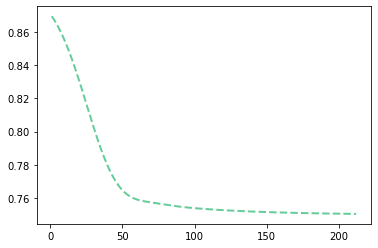

In [56]:
plot(loadLosses('sAttack', 'vqc', 1), color=palette['vqc'])

In [11]:
losses_vqc= []
max_length = 0
for i in range(10):
    losses_vqc.append(loadLosses('sAttack', 'vqc', i + 1))
    max_length = max(max_length, len(losses_vqc[-1]))

for i in range(10):
    length = len(losses_vqc[i])
    while length < max_length:
        losses_vqc[i].append(losses_vqc[i][-1])
        length += 1

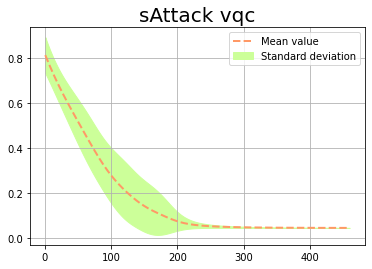

In [30]:
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="sAttack vqc")

### - average time and loss

In [56]:
average_loss_vqc = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sAttack', 'vqc', i + 1)[-1]
    average_loss_vqc += loss
print(f'Average loss for vqc: {average_loss_vqc / MAX_TIMES}')

Average loss for vqc: (0.043472421859086216+0j)


In [57]:
average_epoch_vqc = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sAttack', 'vqc', i + 1)
    average_epoch_vqc += len(loss)
print(f'Average epoch for vqc: {average_epoch_vqc / MAX_TIMES}')

Average epoch for vqc: 373.7


In [58]:
average_time_vqc = 167.38259507000004

In [59]:
average_time_per_epoch_vqc = average_time_vqc / average_epoch_vqc
print(f'Average time per epoch for vqc: {average_time_per_epoch_vqc}')

Average time per epoch for vqc: 0.044790632879314965


| Strategy | VQC |
|:----------------:|:-----:|
| Average loss | 0.04347 |
| Average time | 167.38 |
| Average epochs | 373.7 |
| Average time per epoch | 0.04479 |

##  Summarize

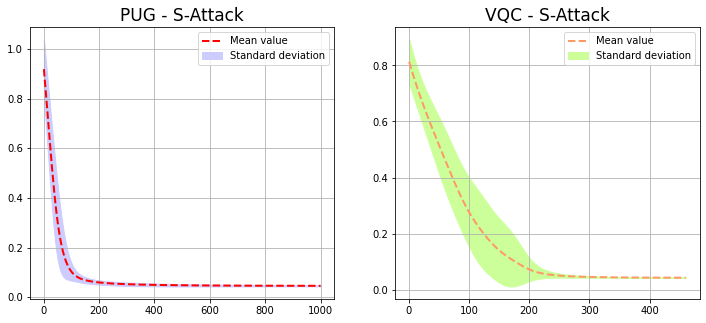

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plotLosses(losses_unitary, title="PUG - S-Attack", fontsize=17)
plt.subplot(1,2,2)
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="VQC - S-Attack", fontsize=17)

|Indicators| PUG |VQC |
|:----------------:|:-----:|:-----:|
| Average loss | 0.04516 |0.04347 |
| Average time | 202.49 | 167.38 |
| Average epochs | 524.0 |373.7 |
| Average time per epoch | 0.03864 | 0.04479 |
| Total Parameters | 16 | 12 |

## Compare Lipschitz

In [26]:
measurements = getMeasurements(2)

In [27]:
names = ['unitary', 'vqc']

In [28]:
error_params = [
    [0.0001 , 'b'], [0.0001 , 'p'], [0.0001 , 'd'], 
    [0.001 , 'b'], [0.001 , 'p'], [0.001 , 'd'], 
    [0.01 , 'b'], [0.01 , 'p'], [0.01 , 'd'],
    [0.1 , 'b'], [0.1 , 'p'], [0.1 , 'd'], 
]

### - exact Lipschitz

In [29]:
smallestDict = { k: 0 for k in names }

for (p, errorType) in error_params:
    print(f' - p = {p}, errorType: {errorType}')
    
    # simulate noise input circuits
    noiseInputCircuits = getNoiseCircuits(inputCircuits + inputHackedCircuits, p, errorType)

    smallest = 1.0; smallestKey = ''
    for name in names: # unitary or vqc
        lip = 0.0
        
        for i in range(MAX_TIMES):
            # build targetCircuit
            params = loadParams('sAttack', name, i + 1)
            targetCircuit = QuantumCircuit(2, 2)
            
            if name == 'unitary':
                targetCircuit.append(buildU(2, params), [0, 1])
            else:
                targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])
                
            lip += calculateExactLipschitz2(
                inputCircuits + inputHackedCircuits, noiseInputCircuits, 
                targetCircuit, outputCircuit, measurements
            )
        lip = lip / MAX_TIMES
        
        if lip < smallest:
            smallest = lip
            smallestKey = name
        
        print(f'Lipschitz for [{name}] is: {lip}\n')
    
    smallestDict[smallestKey]  += 1.0
    print(f'smallest one: [{smallestKey}]')
        
    print('-' * 25)
    print()

print(smallestDict)

 - p = 0.0001, errorType: b
Lipschitz for [unitary] is: 0.2843301299195208

Lipschitz for [vqc] is: 0.20260273885046204

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: p
Lipschitz for [unitary] is: 0.284311911976605

Lipschitz for [vqc] is: 0.20255142810575286

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: d
Lipschitz for [unitary] is: 0.2843748973770756

Lipschitz for [vqc] is: 0.2026158170316609

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: b
Lipschitz for [unitary] is: 0.28401873265035443

Lipschitz for [vqc] is: 0.20253331825572354

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: p
Lipschitz for [unitary] is: 0.2837584282605178

Lipschitz for [vqc] is: 0.20210257653928426

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: d
Lipschitz for [unitary] is: 0.28432653314403034

Lipschitz for [vqc] is: 0.20257318770740618

smallest one: [vqc]
----------------------

<table>
    <tr>
        <th style="text-align: center" rowspan="2">Strategy</th><th style="text-align: center" rowspan="2">Error Type</th><th style="text-align: center" colspan="4">Probability</th>
    </tr>
    <tr>
                                                 <td style="text-align: center">0.0001</td><td style="text-align: center">0.001</td><td style="text-align: center">0.01</td><td style="text-align: center">0.1</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">PUG</td><td style="text-align: center">bit flip</td><td>0.2843</td><td>0.2840</td><td>0.2835</td><td>0.2835</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td>0.2843
</td><td>0.2838</td><td>0.2786</td><td>0.2474</td>
    </tr>
    <tr>
        <td style="text-align: center">depolarizing</td><td>0.2844</td><td>0.2843</td><td> 0.2839</td><td>0.2818</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">VQC</td><td style="text-align: center">bit flip</td><td> 0.2026</td><td>0.2025
</td><td>0.2025</td><td>0.2025</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td>0.2026</td><td>0.2021</td><td>0.1999</td><td>0.1867</td>
    </tr>
    <tr>
        <td style="text-align: center">depolarizing</td><td>0.2026</td><td>0.2026
</td><td>0.2022
</td><td> 0.1987</td>
    </tr>
    
</table>

### - approximate Lipschitz

In [41]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('sAttack', name, i + 1)
        targetCircuit = QuantumCircuit(2, 2)

        if name == 'unitary':
            targetCircuit.append(buildU(2, params), [0, 1])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])

        score = calculateLipschitz(targetCircuit, outputCircuit, measurements)
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
        
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: 0.07791115616388984(best params: No.9(0.0005879899619895492))

Lipschitz for [vqc] is: 0.032524877256801615(best params: No.7(1.4107630947082353e-10))



## validation

In [20]:
unitary_params = loadParams('sAttack', 'unitary', 6)
vqc_params = loadParams('sAttack', 'vqc', 7)

In [21]:
def statisticCount(counts):
    dictionary = {'00': 0, '01': 0, '10': 0, '11': 0}

    for key in counts:
        # dict[key[:2]]
        dictionary[ key[:2] ] += counts[key]

    print(f'1: {dictionary}')

In [22]:
def stat(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 1], [1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    print(counts)
    print()
    statisticCount(counts)

In [23]:
def initVQCFullCircuit(bits, params, hack=False):
    circuit = getOriginCircuit(bits, decode=False)
    if hack:
        circuit.s(0)
        circuit.barrier()

    circuit.u2(params[0],params[1], 0)
    circuit.u2(params[2],params[3], 1)
    circuit.cx(0, 1)
    circuit.u2(params[4],params[5], 0)
    circuit.u2(params[6],params[7], 1)
    circuit.cx(0, 1)
    circuit.u2(params[8],params[9], 0)
    circuit.u2(params[10],params[11], 1)
    
    circuit.barrier()

    circuit.cx(0, 1)
    circuit.h(0)

    return circuit

In [24]:
bits = "11"

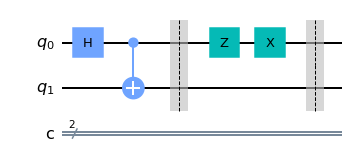

In [25]:
origin_circuit = getOriginCircuit(bits)
origin_circuit.draw(output='mpl')

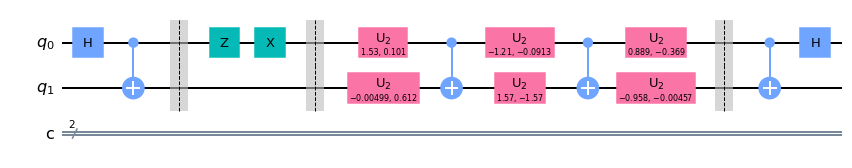

In [26]:
vqc_circuit = initVQCFullCircuit(bits, vqc_params)
vqc_circuit.draw(output='mpl')

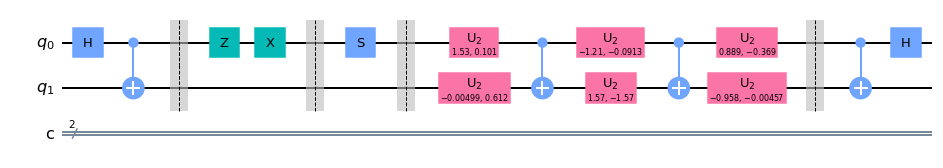

In [27]:
vqc_circuit_hacked = initVQCFullCircuit(bits, vqc_params, True)
vqc_circuit_hacked.draw(output='mpl')

In [29]:
classical_bits = ["00", "10", "01", "11"]

for bits in classical_bits:
    print(f'Testing: {bits}\n')
    origin_circuit = getOriginCircuit(bits, True)
    vqc_circuit = initVQCFullCircuit(bits, vqc_params)
    vqc_circuit_hacked = initVQCFullCircuit(bits, vqc_params, True)

    stat(origin_circuit, shots=10000)
    print('\n' + '-' * 60 + '\n')
    stat(vqc_circuit, shots=10000)
    print('\n' + '-' * 60 + '\n')
    stat(vqc_circuit_hacked, shots=10000)
    print('\n\n')

Testing: 00

{'00': 10000}

1: {'00': 10000, '01': 0, '10': 0, '11': 0}

------------------------------------------------------------

{'00': 8505, '10': 1451, '11': 12, '01': 32}

1: {'00': 8505, '01': 32, '10': 1451, '11': 12}

------------------------------------------------------------

{'00': 8525, '10': 1437, '01': 3, '11': 35}

1: {'00': 8525, '01': 3, '10': 1437, '11': 35}



Testing: 10

{'10': 10000}

1: {'00': 0, '01': 0, '10': 10000, '11': 0}

------------------------------------------------------------

{'10': 8508, '00': 1459, '11': 18, '01': 15}

1: {'00': 1459, '01': 15, '10': 8508, '11': 18}

------------------------------------------------------------

{'10': 8505, '00': 1448, '01': 45, '11': 2}

1: {'00': 1448, '01': 45, '10': 8505, '11': 2}



Testing: 01

{'01': 10000}

1: {'00': 0, '01': 10000, '10': 0, '11': 0}

------------------------------------------------------------

{'11': 1462, '01': 8495, '00': 38, '10': 5}

1: {'00': 38, '01': 8495, '10': 5, '11': 1462}

<table>
   <tr><th style="text-align: center" rowspan="2">Observed String</th><th colspan="4" style="text-align: center">Intended String</th></tr>
          <tr><td>00</td><td>01</td><td>10</td><td>11</td></tr>
   <tr><td style="text-align: center">00</td><td>85.05%</td><td>0.32%</td><td>14.51%</td><td>0.12%</td></tr>
   <tr><td style="text-align: center">01</td><td>0.38%</td><td>84.95%</td><td>0.05%</td><td>14.62%</td></tr>
   <tr><td style="text-align: center">10</td><td>14.59%</td><td>0.15%</td><td>85.08%</td><td>0.18%</td></tr>
   <tr><td style="text-align: center">11</td><td>0.02%</td><td>14.25%</td><td>0.29%</td><td>85.44%</td></tr>
</table>

<table>
   <tr><th style="text-align: center" rowspan="2">Observed String</th><th colspan="4" style="text-align: center">Intended String</th></tr>
          <tr><td>00</td><td>01</td><td>10</td><td>11</td></tr>
   <tr><td style="text-align: center">00</td><td>85.25%</td><td>0.03%</td><td>14.37%</td><td>0.35%</td></tr>
   <tr><td style="text-align: center">01</td><td>0.03%</td><td>84.79%</td><td>0.43%</td><td>14.75%</td></tr>
   <tr><td style="text-align: center">10</td><td>14.48%</td><td>0.45%</td><td>85.05%</td><td>0.02%</td></tr>
   <tr><td style="text-align: center">11</td><td>0.48%</td><td>15.24%</td><td>0.01%</td><td>84.27%</td></tr>
</table>

In [31]:
def initUnitaryFullCircuit(bits, params, hack=False):
    circuit = getOriginCircuit(bits, decode=False)
    if hack:
        circuit.s(0)
        circuit.barrier()

    circuit.append(buildU(2, params), [0, 1])
    
    circuit.barrier()

    circuit.cx(0, 1)
    circuit.h(0)

    return circuit

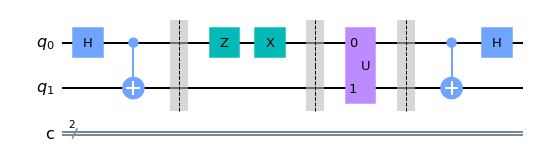

In [47]:
unitary_circuit = initUnitaryFullCircuit(bits, unitary_params)
unitary_circuit.draw(output='mpl')

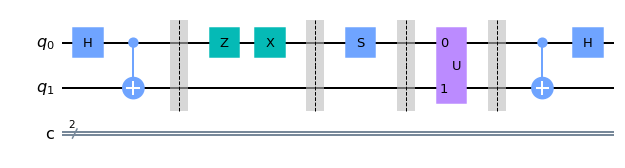

In [48]:
unitary_circuit_hacked = initUnitaryFullCircuit(bits, unitary_params, hack=True)
unitary_circuit_hacked.draw(output='mpl')

In [34]:
classical_bits = ["00", "10", "01", "11"]

for bits in classical_bits:
    print(f'Testing: {bits}\n')
    origin_circuit = getOriginCircuit(bits, True)
    unitary_circuit = initUnitaryFullCircuit(bits, unitary_params)
    unitary_circuit_hacked = initUnitaryFullCircuit(bits, unitary_params, hack=True)

    stat(origin_circuit, shots=10000)
    print('\n' + '-' * 60 + '\n')
    stat(unitary_circuit, shots=10000)
    print('\n' + '-' * 60 + '\n')
    stat(unitary_circuit_hacked, shots=10000)
    print('\n\n')

Testing: 00

{'00': 10000}

1: {'00': 10000, '01': 0, '10': 0, '11': 0}

------------------------------------------------------------

{'00': 8421, '10': 1570, '01': 5, '11': 4}

1: {'00': 8421, '01': 5, '10': 1570, '11': 4}

------------------------------------------------------------

{'00': 8534, '10': 1455, '01': 10, '11': 1}

1: {'00': 8534, '01': 10, '10': 1455, '11': 1}



Testing: 10

{'10': 10000}

1: {'00': 0, '01': 0, '10': 10000, '11': 0}

------------------------------------------------------------

{'00': 1529, '10': 8449, '11': 14, '01': 8}

1: {'00': 1529, '01': 8, '10': 8449, '11': 14}

------------------------------------------------------------

{'10': 8517, '00': 1468, '11': 13, '01': 2}

1: {'00': 1468, '01': 2, '10': 8517, '11': 13}



Testing: 01

{'01': 10000}

1: {'00': 0, '01': 10000, '10': 0, '11': 0}

------------------------------------------------------------

{'01': 8496, '11': 1490, '00': 13, '10': 1}

1: {'00': 13, '01': 8496, '10': 1, '11': 1490}

----

<table>
   <tr><th style="text-align: center" rowspan="2">Observed String</th><th colspan="4" style="text-align: center">Intended String</th></tr>
          <tr><td>00</td><td>01</td><td>10</td><td>11</td></tr>
   <tr><td style="text-align: center">00</td><td>84.21%</td><td>0.05%</td><td>15.70%</td><td>0.04%</td></tr>
   <tr><td style="text-align: center">01</td><td>0.13%</td><td>84.96%</td><td>0.01%</td><td>14.90%</td></tr>
   <tr><td style="text-align: center">10</td><td>15.29%</td><td>0.08%</td><td>84.49%</td><td>0.14%</td></tr>
   <tr><td style="text-align: center">11</td><td>0.01%</td><td>14.77%</td><td>0.21%</td><td>85.01%</td></tr>
</table>

<table>
   <tr><th style="text-align: center" rowspan="2">Observed String</th><th colspan="4" style="text-align: center">Intended String</th></tr>
          <tr><td>00</td><td>01</td><td>10</td><td>11</td></tr>
   <tr><td style="text-align: center">00</td><td>85.34%</td><td>0.10%</td><td>14.55%</td><td>0.01%</td></tr>
   <tr><td style="text-align: center">01</td><td>0.05%</td><td>85.34%</td><td>0.09%</td><td>14.52%</td></tr>
   <tr><td style="text-align: center">10</td><td>14.68%</td><td>0.10%</td><td>85.17%</td><td>0.13%</td></tr>
   <tr><td style="text-align: center">11</td><td>0.09%</td><td>15.25%</td><td>0.05%</td><td>84.61%</td></tr>
</table>